In [2]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
import re
import glob

In [3]:
def convergencia(tiempo, fotones, tol=1e-3, porcentaje=0.1):
    npoints = int(len(tiempo) * porcentaje)
    if npoints < 2:
        return False, np.nan # no hay suficientes puntos

    fotones = fotones[-npoints:]
    tiempo = tiempo[-npoints:]
    
    df = np.gradient(fotones, tiempo)
    df_mean = np.mean(np.abs(df))
    
    return df_mean < tol, df_mean

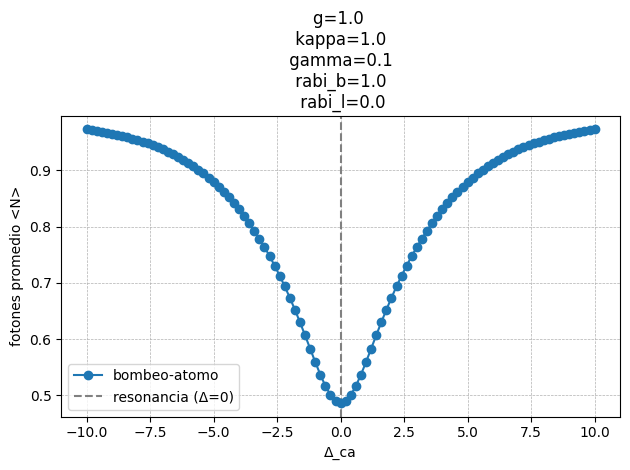

In [4]:
path = "1at2lvl/"
sistemas = ["bombeo-atomo"]
delta = "ca"

for sistema in sistemas:
    detunings = []
    Nss = []
    converged = []
    non_converged = []
    files = glob.glob(os.path.join(f'{path}{sistema}-{delta}', '*.h5'))
    for file in files:
        with h5py.File(file, 'r') as f:
            dataset = os.path.basename(file).replace('.h5', '')
            g = f[dataset].attrs['g']
            kappa = f[dataset].attrs['kappa']
            gamma = f[dataset].attrs['gamma']
            rabi_b = f[dataset].attrs['rabi_b']
            rabi_l = f[dataset].attrs['rabi_l']
            detuning = f[dataset].attrs[f'detuning_{delta}']
            tt = f[dataset].attrs['t']
            tiempo = np.linspace(float(tt[0]), float(tt[1]), int(tt[2]))
    
            if dataset not in f:
                print(f"  no se encontró el dataset '{dataset}' en el archivo. Saltando.")
                continue
                
            rho = f[dataset][:]
            N_expect = rho[:, 0]
            
            is_converged, derivative = convergencia(tiempo, N_expect)
            
            # promediamos el último 25% de los puntos para obtener el valor de N_ss
            npoints = int(len(N_expect) * 0.25)
            ns = np.mean(N_expect[-npoints:])
            detunings.append(detuning)
            Nss.append(ns)
            
            if is_converged:
                converged.append((detuning, ns))
            else:
                print(f"  detuning={detuning:.2f} podría no haber convergido (derivada = {derivative:.2e})")
                non_converged.append((detuning, ns))

    # convierte a lista de numpy
    detunings = np.array(detunings)
    Nss = np.array(Nss)
    # ordena por detuning para mejorar la gráfica
    sorti = np.argsort(detunings)
    detunings = detunings[sorti]
    Nss = Nss[sorti]
    
    
    plt.plot(detunings, Nss, 'o-', label=sistema, zorder=5)
    if non_converged:
        nc_det, nc_N = zip(*non_converged)
        plt.scatter(nc_det, nc_N, color='red', s=100, marker='o')
    
plt.axvline(0, color='gray', linestyle='--', label='resonancia (Δ=0)')
plt.xlabel(f"Δ_{delta}")
plt.ylabel("fotones promedio <N>")
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.title(f'g={g} \n kappa={kappa} \n gamma={gamma} \n rabi_b={rabi_b} \n rabi_l={rabi_l}')
plt.legend()
plt.tight_layout()
#plt.savefig("espectro_cavidad.png", dpi=300)
plt.show()